In [1]:
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from relaynet import RelayNet, DenseBlock
from data_utils import get_imdb_data
from train import valid
from utils import error_map_dice

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/magnus/Documents/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_data, test_data = get_imdb_data()
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 88
Test size: 22


In [3]:
relay_net = RelayNet(dropout_prob=0, basic_block=DenseBlock)
relay_net.load_state_dict(torch.load('models_dense/model-89.model'))
relay_net = relay_net.cuda()
relay_net.eval()

In [4]:
args = namedtuple('Args', ['batch_size', 'cuda'])
valid(test_data, relay_net, args(batch_size=2, cuda=True))

100%|██████████| 11/11 [00:01<00:00, 10.97it/s]


Validation dice avg: 0.7811333591287787


/home/magnus/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


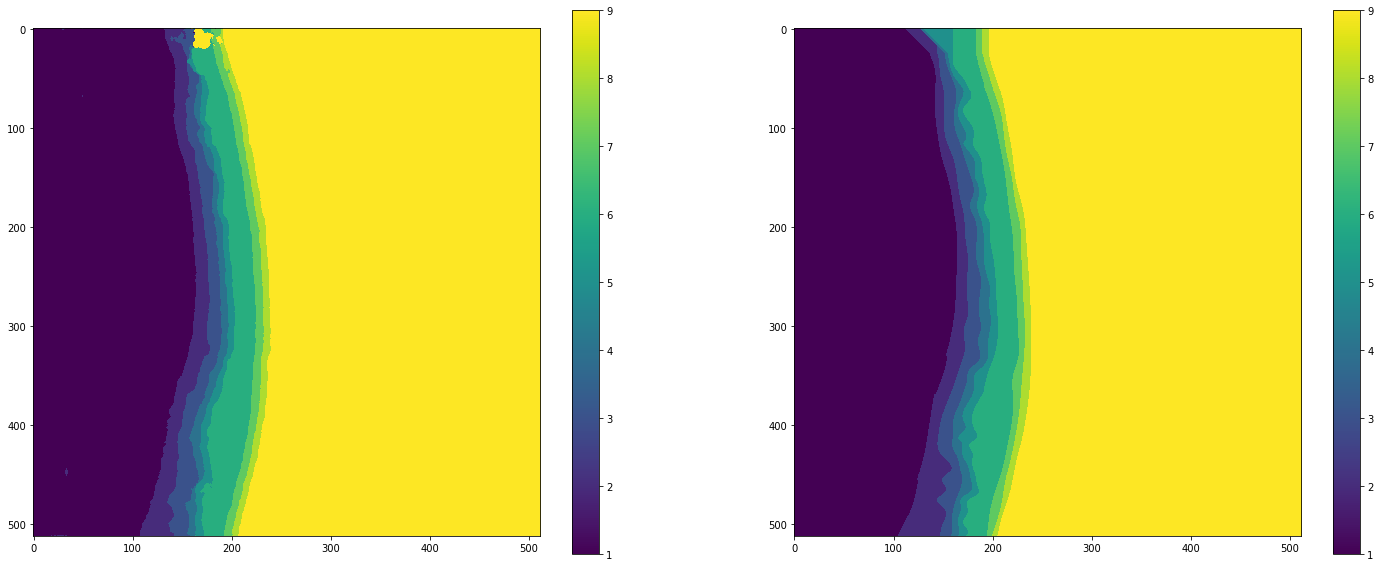

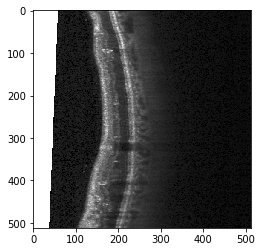

In [5]:
out = relay_net(Variable(torch.Tensor(test_data.X[11:12]).cuda(),volatile=True))
idx = np.argmax(out.data, 1).squeeze()

plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(idx)
plt.colorbar()

plt.subplot(122)
img_test = test_data.y[11:12]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.colorbar()
plt.show()


img_test = test_data.X[11:12]
img_test = np.squeeze(img_test)
plt.imshow(img_test, cmap='gray')
plt.show()
del out, idx, relay_net

In [6]:
relay_net = RelayNet(dropout_prob=0.3, basic_block=DenseBlock)
relay_net.load_state_dict(torch.load('models_dense_dropout/model-89.model'))
relay_net = relay_net.cuda()
relay_net.eval()

In [7]:
valid(test_data, relay_net, args(batch_size=2, cuda=True), mc_samples=30)

100%|██████████| 11/11 [01:39<00:00,  9.03s/it]

Validation dice avg: 0.7860456596721302


In [8]:
error_map_dice(test_data, relay_net, args(batch_size=2, cuda=True))

100%|██████████| 11/11 [00:33<00:00,  3.04s/it]

dice avg: 0.431232289834456


0.431232289834456

/home/magnus/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


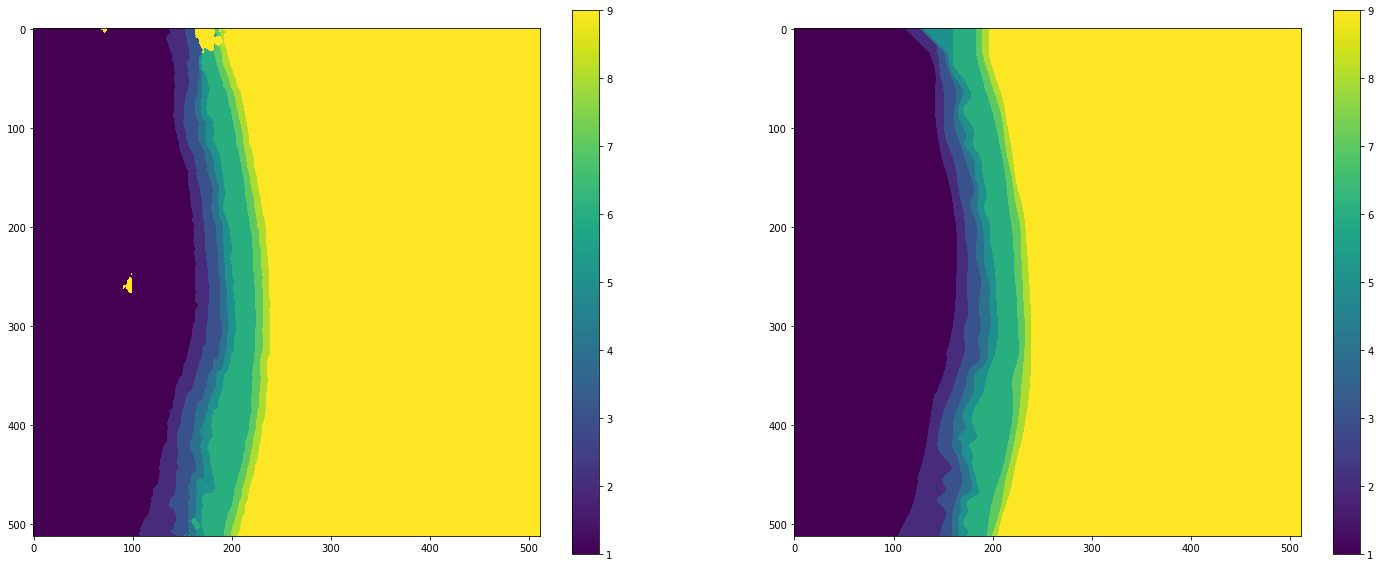

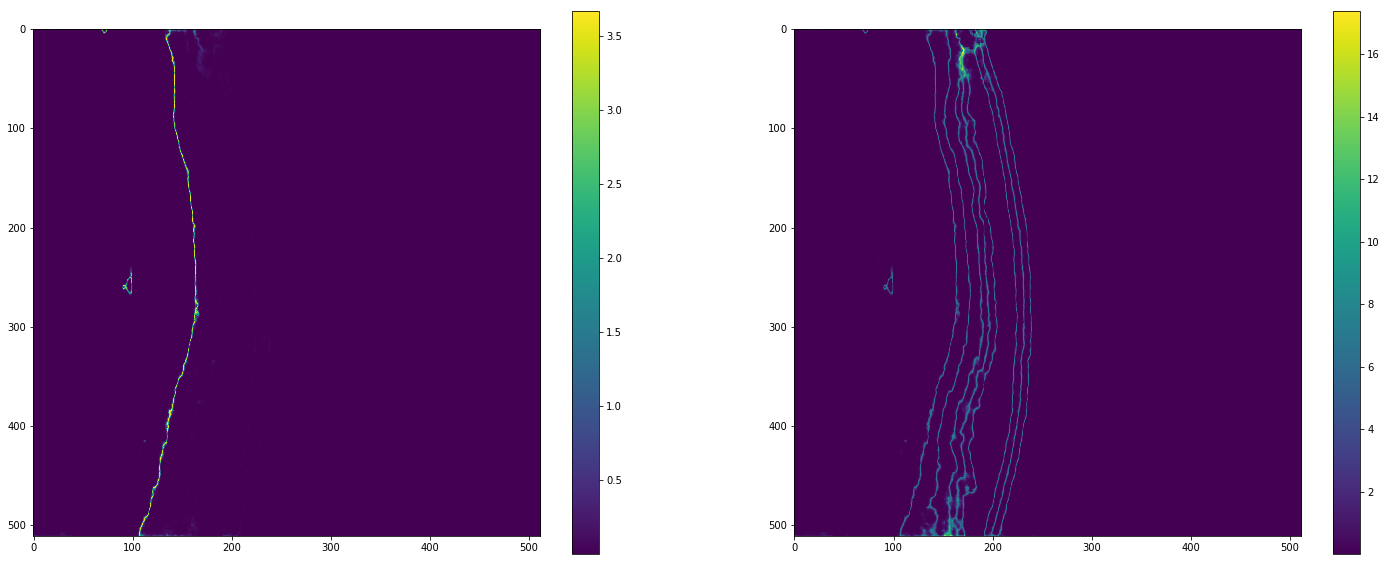

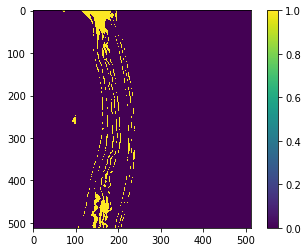

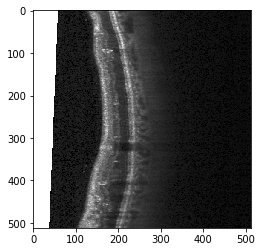

In [9]:
avg, per_class_entropy, overall_entropy = relay_net.predict(Variable(torch.Tensor(test_data.X[11:12]).cuda(),volatile=True))

idx = np.argmax(avg,0)
plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(idx)
plt.colorbar()

plt.subplot(122)
img_test = test_data.y[11:12]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.colorbar()
plt.show()

plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(np.squeeze(per_class_entropy)[1])
plt.colorbar()

plt.subplot(122)
plt.imshow(np.squeeze(overall_entropy))
plt.colorbar()
plt.show()

error_map = idx != test_data.y[11:12].astype(np.int)
plt.imshow(error_map.squeeze().astype(np.int))
plt.colorbar()
plt.show()

img_test = test_data.X[11:12]
img_test = np.squeeze(img_test)
plt.imshow(img_test, cmap='gray')
plt.show()

number of samples: 2


/home/magnus/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


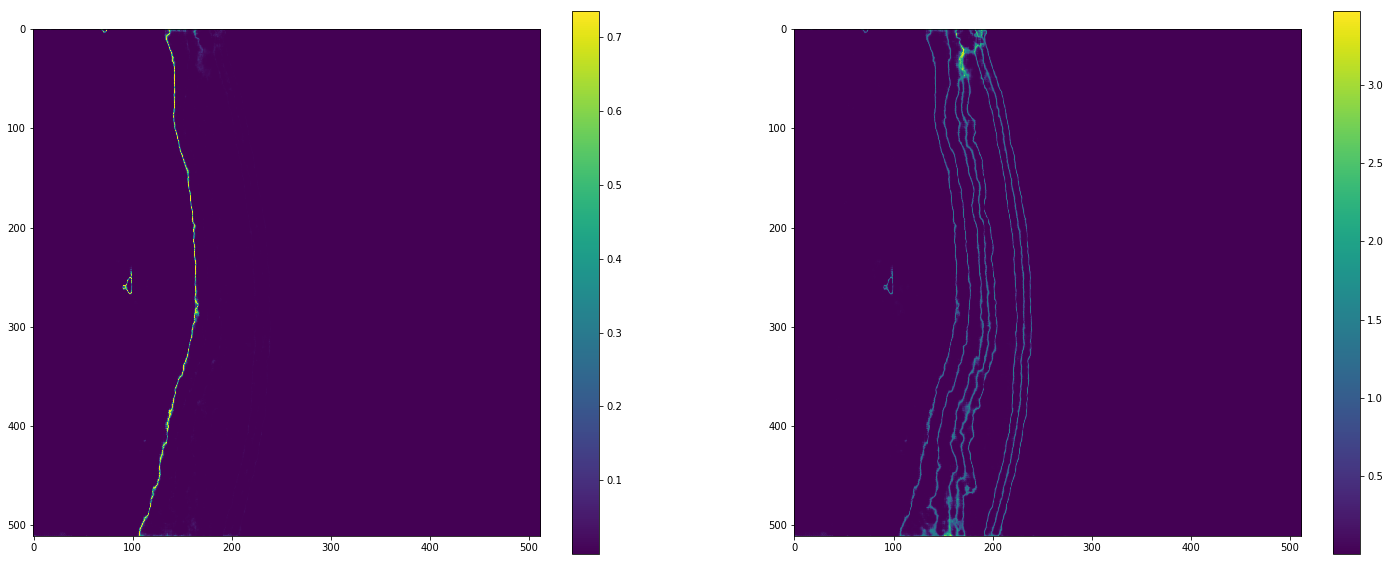

number of samples: 5


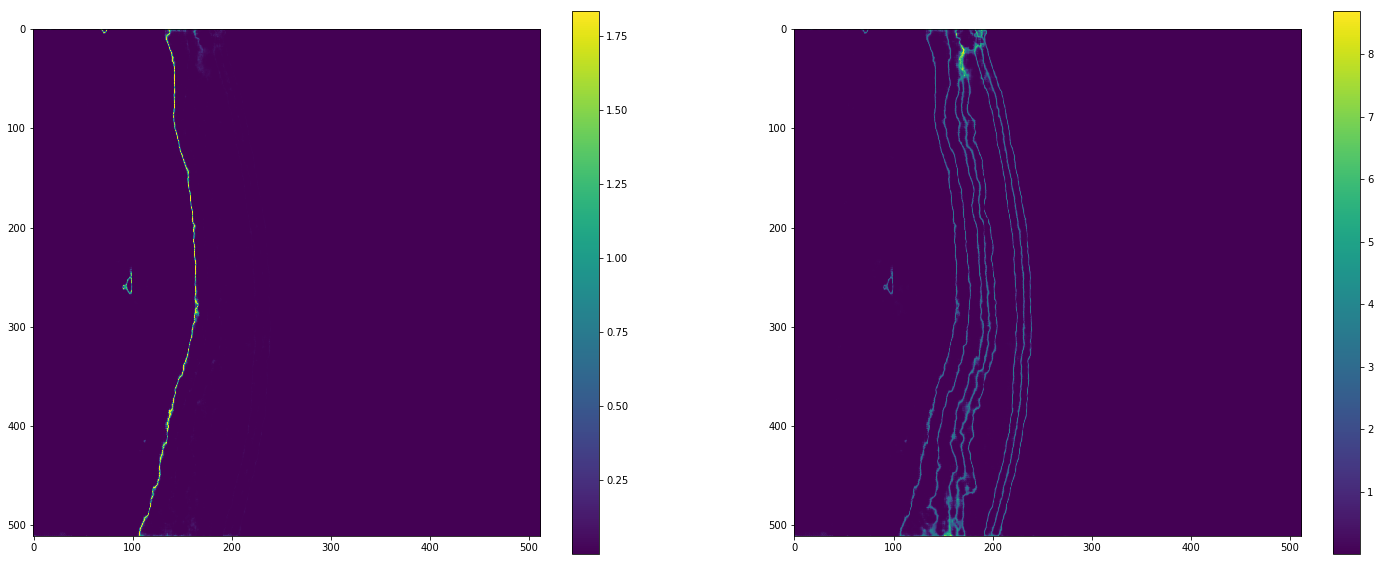

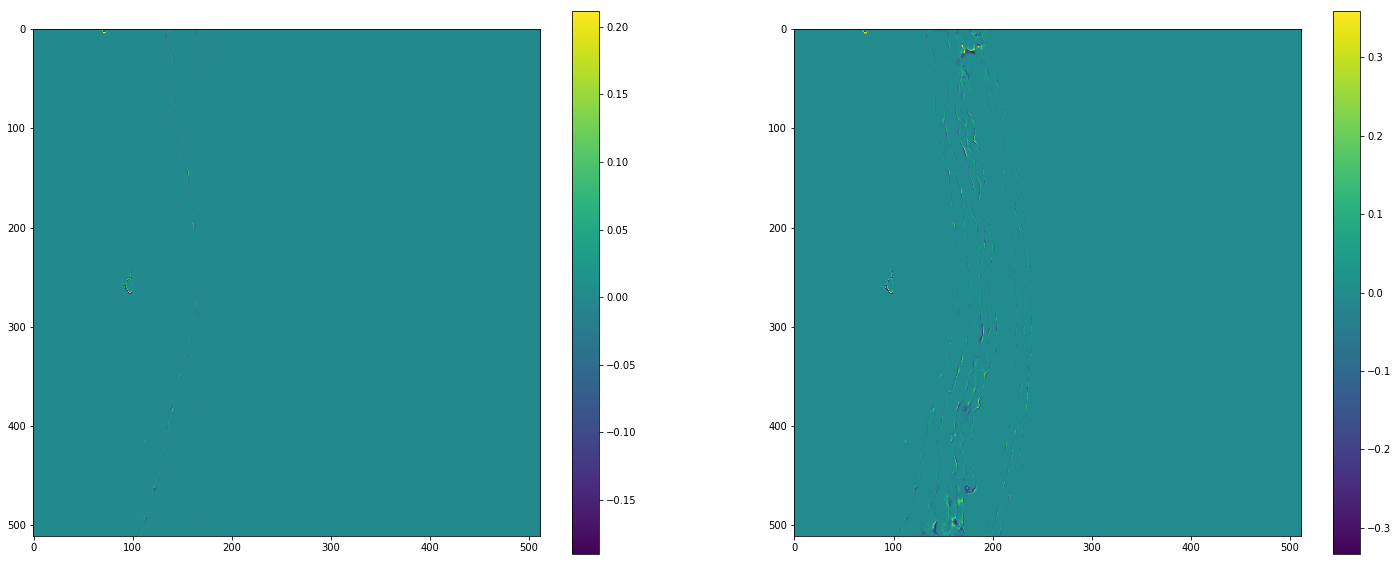

number of samples: 10


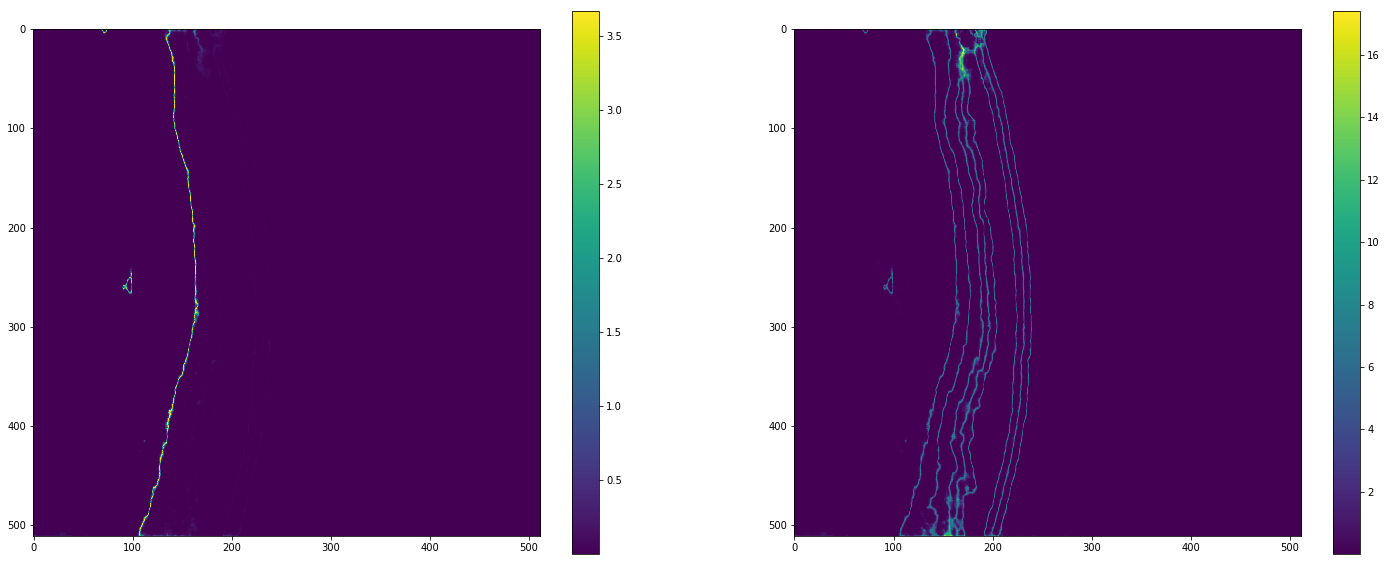

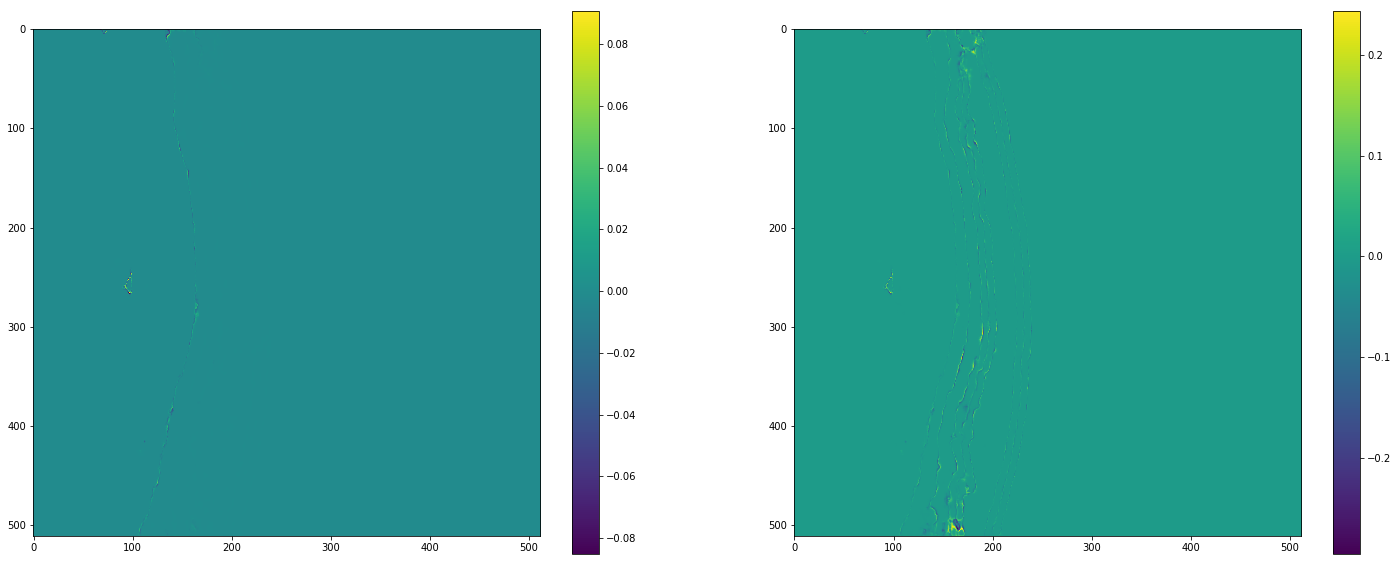

number of samples: 50


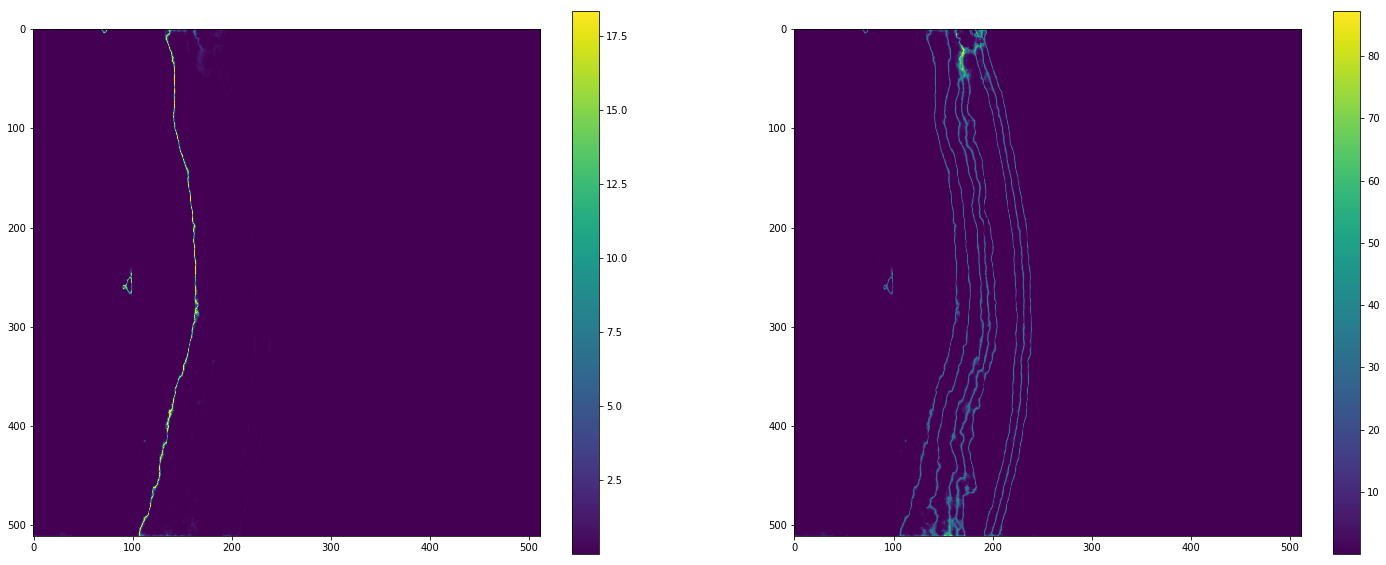

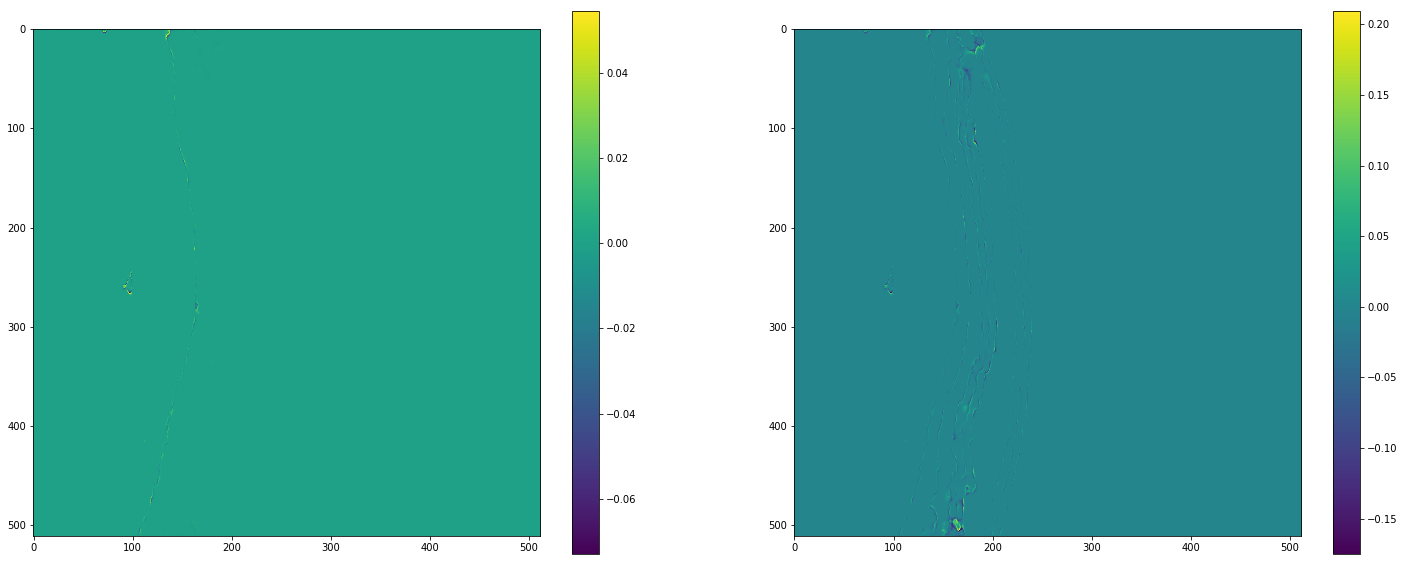

number of samples: 100


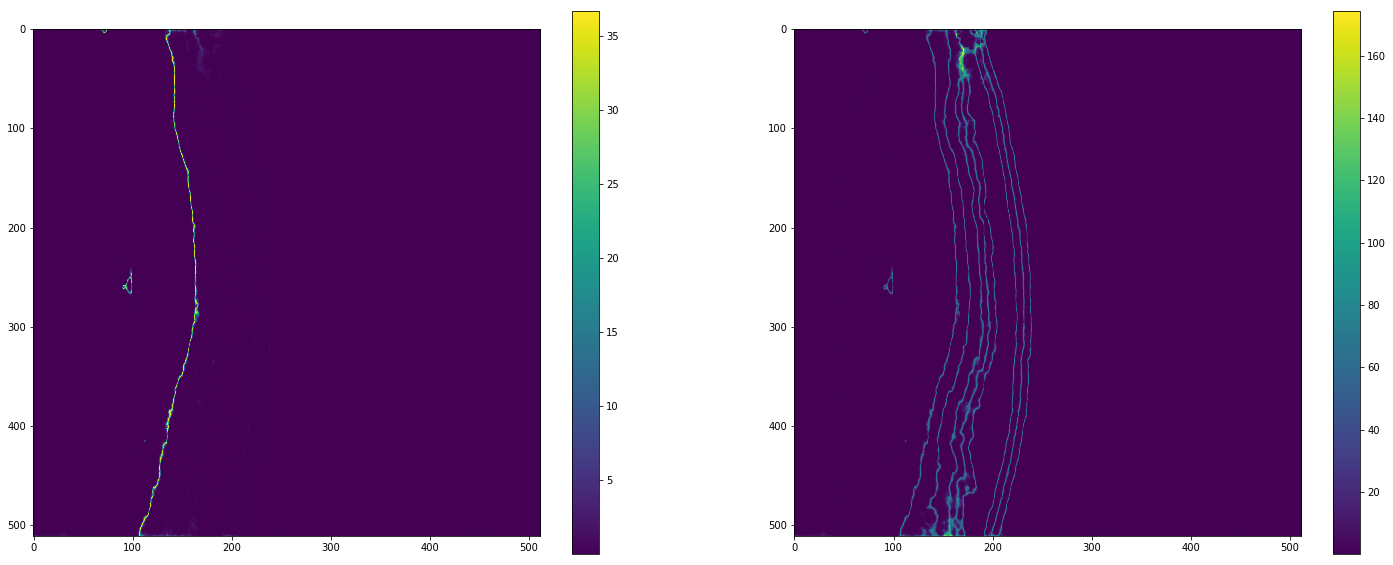

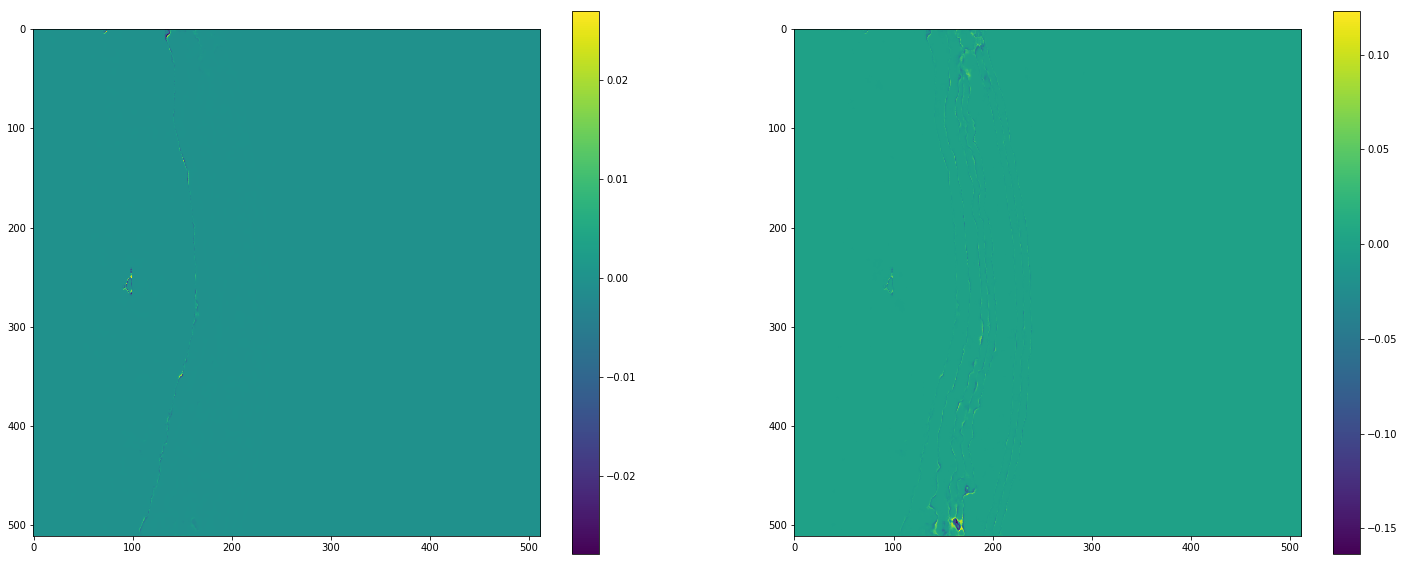

number of samples: 300


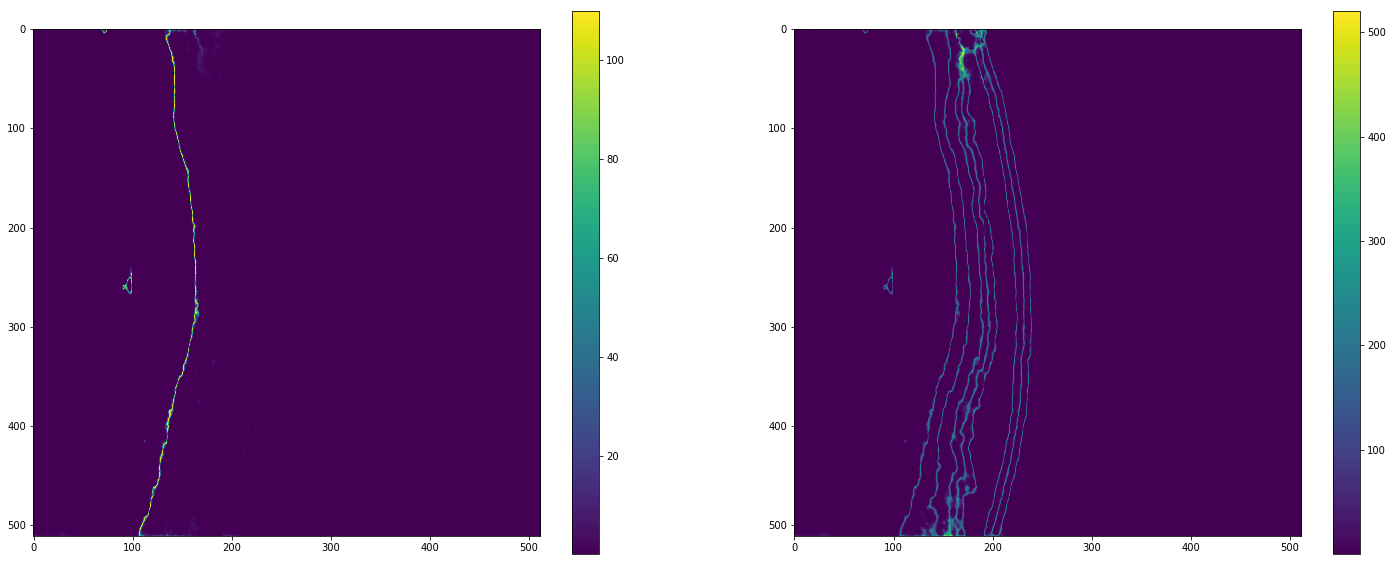

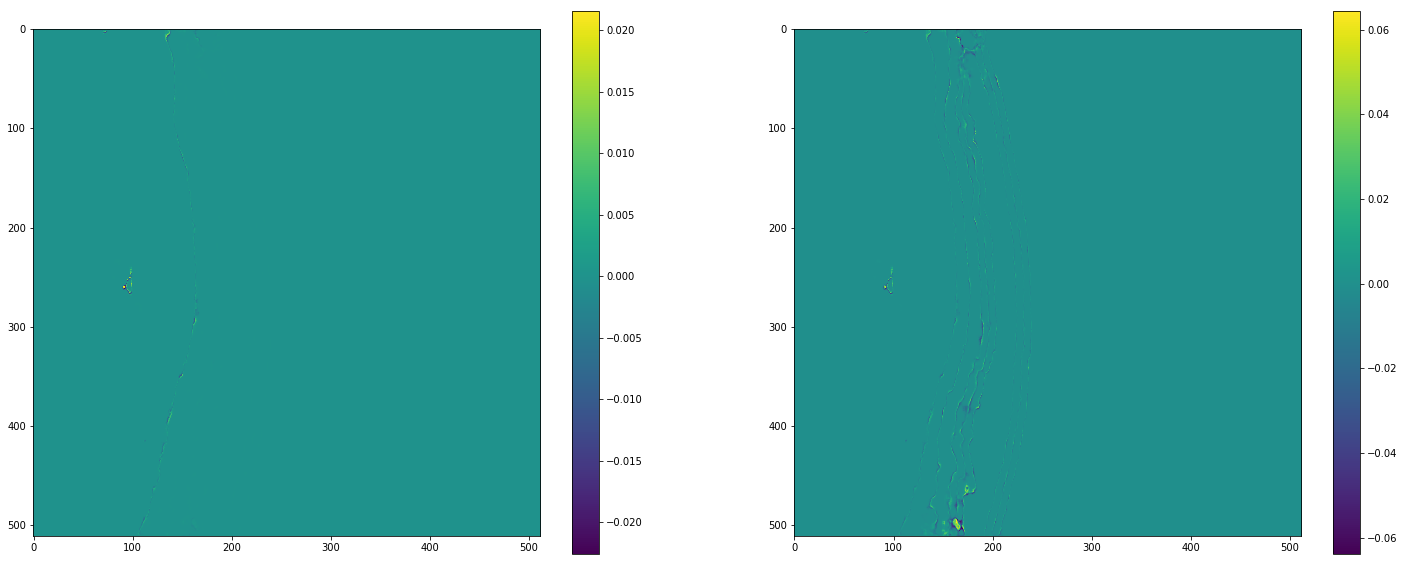

number of samples: 500


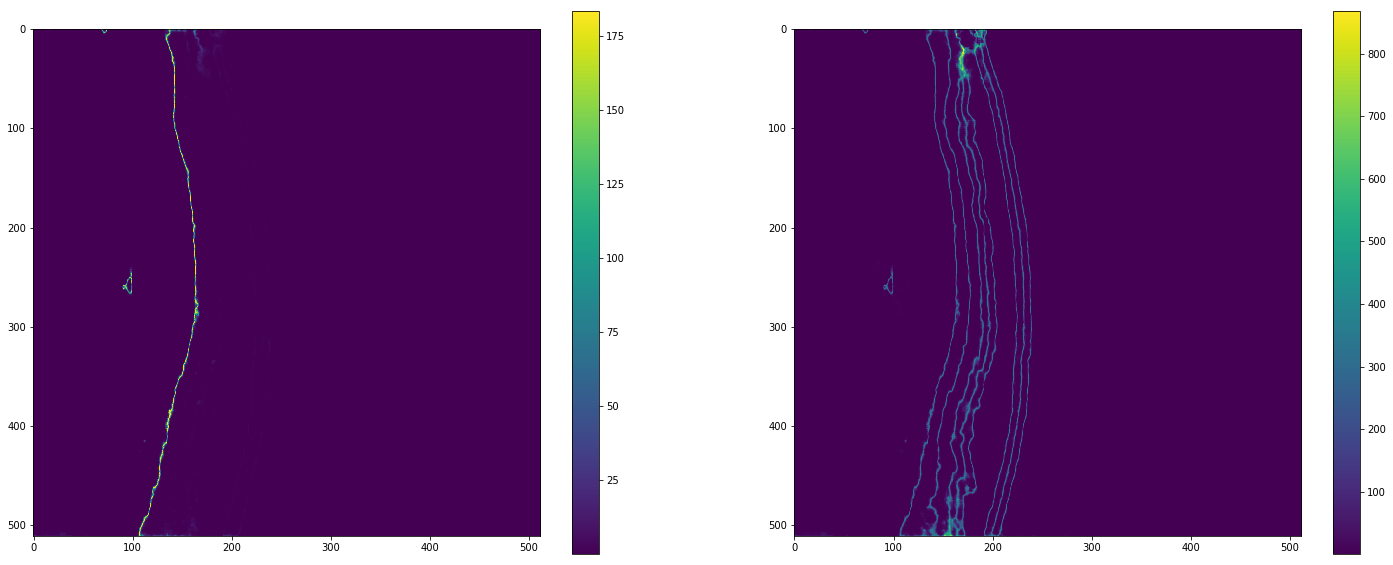

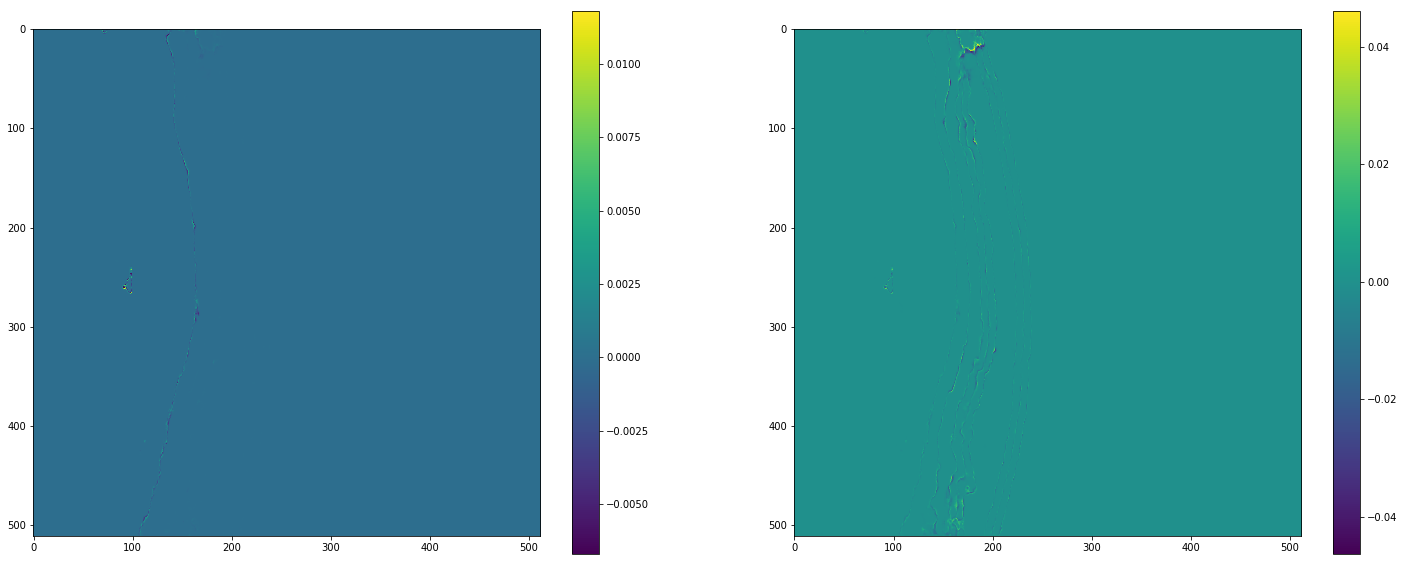

In [10]:
last = None
for i in [2, 5, 10, 50, 100, 300, 500]:
    plt.figure(figsize=(25,10))
    print('number of samples: {}'.format(i))
    avg, per_class_entropy, overall_entropy = relay_net.predict(
        Variable(torch.Tensor(test_data.X[11:12]).cuda(),volatile=True), 
        times=i)
    
    plt.subplot(121)
    plt.imshow(np.squeeze(per_class_entropy)[1])
    plt.colorbar()
    
    plt.subplot(122)
    plt.imshow(np.squeeze(overall_entropy))
    plt.colorbar()
    plt.show()
    
    if last is not None:
        plt.figure(figsize=(25,10))
        last_per_class_entropy, last_overall_entropy, last_i = last
        plt.subplot(121)
        plt.imshow(np.squeeze(per_class_entropy / i - last_per_class_entropy / last_i)[1])
        plt.colorbar()
    
        plt.subplot(122)
        plt.imshow(np.squeeze(overall_entropy / i - last_overall_entropy / last_i))
        plt.colorbar()
        plt.show()
        
    last = per_class_entropy, overall_entropy, i